<font size=8> **Plotting sea ice in the Southern Ocean** </font>  
  
This notebooks examines sea ice area concentration (SIC), sea ice extent (SIE) and total area of marginal ice zone (MIZ) in the Southern Ocean using outputs from ACCESS-OM2-01.  
  
Comparison with observations was done using the [NASA Goddard-merged Near Real Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-nasa-goddard-and-nsidc-based-nasa-team-algorithm) (version 3). Note that the observations have data missing on some dates before February 1988, therefore we had to replace the missing dates with some interpolated data. This process is described in full in the [Sea Ice Seasonality notebook](https://github.com/lidefi87/ACCESS-OM2-01_EcologicallyRelevantVariables/blob/main/Scripts/SeaIceSeasonality.ipynb).

The two datasets (model and observations) used in this notebook can be found in GADI.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

You can print your working directory using the chunk below to make sure you are in the correct folder containing these notebooks.

In [ ]:
!pwd

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [2]:
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
from dask.distributed import Client, progress
from glob import glob
#Importing script containing useful functions
import ZonalStatsFunctions as zsf
import datetime as dt
import xesmf as xe
from itertools import cycle
import string

The following modules are used in plotting maps and time series.

In [3]:
#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import geopandas

#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Accessing ACCESS-OM2-01 outputs
We will start a cluster that has multiple cores to work with and make analyses faster. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
  
If the line below does not run, you can skip it. The result is that the job will not be parallelised, but the script will still run.

In [4]:
client = Client()

We will now need to a new start in the COSIMA cookbook, which will give us access to the default ACCESS-OM2 experiment database from where we will load the data of our interest.

In [22]:
session = cc.database.create_session()

## Set up dictionary of variables prior accessing ACCESS-OM2 model outputs
The dictionary below contains a list of variables containing information that will be used multiple times throughout this notebook. Largely these are file paths to folders where data is either stored or saved. Ensure you update these variables based on your needs.

In [6]:
varDict =  {'var_id': 'aice_m',
            'model': 'ACCESS-OM2-01',
             'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
             'freq': '1 monthly',
             'start_date': range(1965, 2018, 1),
             'offset': np.nan,
             'long_name': 'sea ice area',
             'short_name': 'SIA',
             'unit': '$m^2$',
             'CICE_data': True,
             'base_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/Data',
             'climatologies': r'/g/data/v45/la6889/Calculations/SeaIceArea/Climatologies',
             'clim_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/Climatologies',
             'linear_trends': r'/g/data/v45/la6889/Calculations/SeaIceArea/LinearTrends',
             'lm_fig': r'/g/data/v45/la6889/Figures/SeaIceArea/LinearTrends',
             'clipped_data': r'/g/data/v45/la6889/Calculations/SeaIceArea/ClippedMEASOregions/',
             'weighted_std_monthly': r'/g/data/v45/la6889/Calculations/SeaIceArea/YearlyMonthly/StdDev',
             'decades': range(1965, 2019, 10),
             'res': '0.1°'}

# Loading ACCESS-OM2 outputs for Sea Ice Concentration in the Southern Ocean
We will use the COSIMA Cookbook to search and load the SIC data we need, we will then extract data for the Southern Ocean only, correct the longitude values, and finally save it to our disk to avoid having to apply this step every time we need access to this data.

In [7]:
dir_out = varDict['base_data']
os.makedirs(dir_out, exist_ok = True)

for yr in varDict['decades']:
    #Accessing data per decade
    stime = f'{str(yr)}-01'
    etime = f'{str(yr+9)}-12'
    #Accessing ACCESS 0.1deg outputs for the entire time range of interest
    SO = zsf.getACCESSdata(varDict['var_id'], stime, etime,
                           freq = varDict['freq'], 
                           ses = session, minlat = -80, maxlat = -35,
                           ice_data = varDict['CICE_data'])
    #Correcting longitudes
    SO = zsf.corrlong(SO)
    #Creating name of file    
    fn = f'SeaIceConcentration_{str(yr)}-{str(yr+9)}.nc'
    #Saving file
    SO.to_netcdf(os.path.join(dir_out, fn))

## Loading longitude corrected sea ice concentration data saved in previous step
SIC less than 0.1 were removed from model ouputs to match the algorithm used in the NASA Goddard data, which considers pixels with SIC estimates less than 0.1 as open water (see page 30 of [User Guide](https://nsidc.org/data/g02202/versions/3)).

In [7]:
#Concantenating all files into a single data array
SIC = xr.open_mfdataset(glob(os.path.join(varDict['base_data'], '*Conc*.nc'))).aice_m
SIC = SIC.sel(time = slice('1978-12', '2018-11'))
SIC

<xarray.DataArray 'aice_m' (time: 480, yt_ocean: 844, xt_ocean: 3600)>
dask.array<getitem, shape=(480, 844, 3600), dtype=float32, chunksize=(120, 844, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1978-12-31T12:00:00 ... 2018-11-30T12:00:00
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -35.2 -35.12 -35.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...
    coordinates:    TLON TLAT time

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

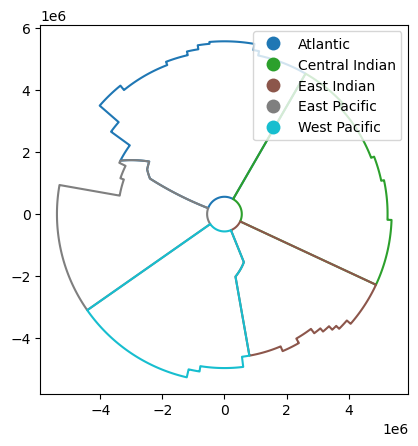

In [15]:
#Load shapefile
MEASO = geopandas.read_file('../SupportingData/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

# Sea Ice Concentration from observations

## Loading corrected SIC data from disk
The observational data is summarised as montly means to match the model output temporal resolution.

In [7]:
#Loading observations
obs = xr.open_mfdataset(glob('/g/data/v45/la6889/Observations/*.nc')).goddard_merged_seaice_conc
#Subsetting data to match definition of seasons 
obs = obs.sel(time = slice('1978-12', '2018-11'))

#Calculating monthly means to match model data
#Empty variable to store results
iceObs = []
#Looping through each year
for yr, da in obs.groupby('time.year'):
    #Calculating monthly means per year
    mon = da.groupby('time.month').mean('time')
    #Changing month dimension back to time with dates
    time = pd.date_range(f'{yr}-{mon.month.values.min()}', 
                         f'{yr}-{mon.month.values.max()}', freq = 'MS')
    mon = mon.rename({'month': 'time'})
    mon['time'] = time
    #Putting all results in one variable
    iceObs.append(mon)

#Load everything in a single data array and renaming variables prior to regridding
iceObs = xr.concat(iceObs, dim = 'time').rename({'longitude': 'lon', 'latitude': 'lat'})

#Removing variables that are not longer needed
del obs, mon, time

# Comparing model and observations estimates in sea ice seasonality
Note that the model data will be regridded to match the observations before comparisons are performed. SIC less than 0.1 were removed from model ouputs to match the algorithm used in the NASA Goddard data, which considers pixels with SIC estimates less than 0.1 as open water (see page 30 of [User Guide](https://nsidc.org/data/g02202/versions/3)).

## Regridding model outputs (coarsening data)
First, the `x` and `y` axes (containing coordinates) in the data arrays of observations and model data need to be renamed.

In [10]:
mod = SIC.where(SIC >= 0.1).fillna(0).rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
mod

<xarray.DataArray 'aice_m' (time: 480, lat: 844, lon: 3600)>
dask.array<where, shape=(480, 844, 3600), dtype=float32, chunksize=(120, 844, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1978-12-31T12:00:00 ... 2018-11-30T12:00:00
  * lon      (lon) float64 -179.9 -179.8 -179.7 -179.6 ... 179.7 179.8 179.9
  * lat      (lat) float64 -79.97 -79.93 -79.88 -79.84 ... -35.2 -35.12 -35.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...
    coordinates:    TLON TLAT time

Extracting grids for the model data and the observations.

In [12]:
grid_in = {'lon': mod.lon.values, 'lat': mod.lat.values}
grid_out = {'lon': iceObs.lon.values, 'lat': iceObs.lat.values}

Calculating regridder using the information above. Bilinear interpolation chosen.

In [13]:
#We only need to calculate the regridder once
reg_coarse = xe.Regridder(grid_in, grid_out, 'bilinear')

Applying regridder to model and saving regridded data.

In [14]:
#Applying regridder
reg_mod_all = reg_coarse(mod)
#Renaming and adding same dimensions as observations
reg_mod_all = reg_mod_all.rename({'y': 'ygrid'}).rename({'x': 'xgrid'})
reg_mod_all = reg_mod_all.assign_coords({'ygrid': iceObs.ygrid}).assign_coords({'xgrid': iceObs.xgrid})

Saving regridded data.

In [21]:
#Saving regridded data
folder_out = os.path.join(varDict['base_data'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)
fn = f'SIC_regridded-mod_all_1979-2018.nc'
reg_mod_all.to_netcdf(os.path.join(folder_out, fn))

### Loading regridded data to avoid recalculating

In [8]:
folder_out = os.path.join(varDict['base_data'], 'Regridded')
reg_mod_all = xr.open_dataarray(glob(os.path.join(folder_out, '*all*.nc'))[0])

## Splitting data into seasons
Calculating seasonal climatologies based on our definition of seasons below.

### Defining seasons

In [11]:
seasonName = {'Summer': [12, 1, 2], 'Autumn': [3, 4, 5], 
              'Winter': [6, 7, 8], 'Spring': [9, 10, 11]}

seasons = {'DJF': 'Summer', 'MAM': 'Autumn', 
           'JJA': 'Winter', 'SON':'Spring'}

### Model data

In [12]:
seasons_SIC = {}
for s, da in SIC.groupby('time.season'):
    seasons_SIC[seasons[s]] = da

### Regridded model data
Saving seasonal regridded data to disk

In [13]:
#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['base_data'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Starting empty dictionary to save results
reg_mod = {}
for s, da in reg_mod_all.groupby('time.season'):
    key = seasons[s]
    reg_mod[key] = da
    fn = f'SIC_regridded-mod_{key}_1979-2018.nc'
    reg_mod[key].to_netcdf(os.path.join(folder_out, fn))

Loading regridded model data to avoid recalculating

In [14]:
#Location of observation files
filelist = sorted(glob(os.path.join(varDict['base_data'], 'Regridded', 'SIC_regridded*.nc')))

#Starting empty dictionary to save results
reg_mod = {}
#Looping through each season
for season in seasonName.keys():
    f = [f for f in filelist if season in f]
    reg_mod[season] = xr.open_dataarray(f[0])

### Observational data

In [15]:
seasons_SIC_obs = {}
for s, da in iceObs.groupby('time.season'):
    #Matching dates with regridded model data
    da['time'] = reg_mod[seasons[s]].time.values
    seasons_SIC_obs[seasons[s]] = da

## Calculating differences and RMSE in seasonal climatologies
Differences in seasonal climatologies between model and observations. Root Mean Square Error (RMSE) calculated per pixel.

In [16]:
#Initialising empty dictionary to store results
clim_dif = {}
rmse = {}

#Calculate model climatology and differences between datasets
for season in seasonName:
    #Changing to percentages
    clim_dif[season] = (reg_mod[season].mean('time')-seasons_SIC_obs[season].mean('time'))*100
    #RMSE
    rmse[season] = np.sqrt(((reg_mod[season]-seasons_SIC_obs[season])**2).mean('time'))

## Plotting results - Figure 2 in publication
Plots include seasonal climatology from model outputs and observations, differences between these (model-obs) and RMSE.  
  
First, we will load the sea ice concentration data (obs and model) so the seasonal climatological mean for sea ice extent can be included in the plot. Then, we will create the final figure that was included in the publication associated to these notebooks.

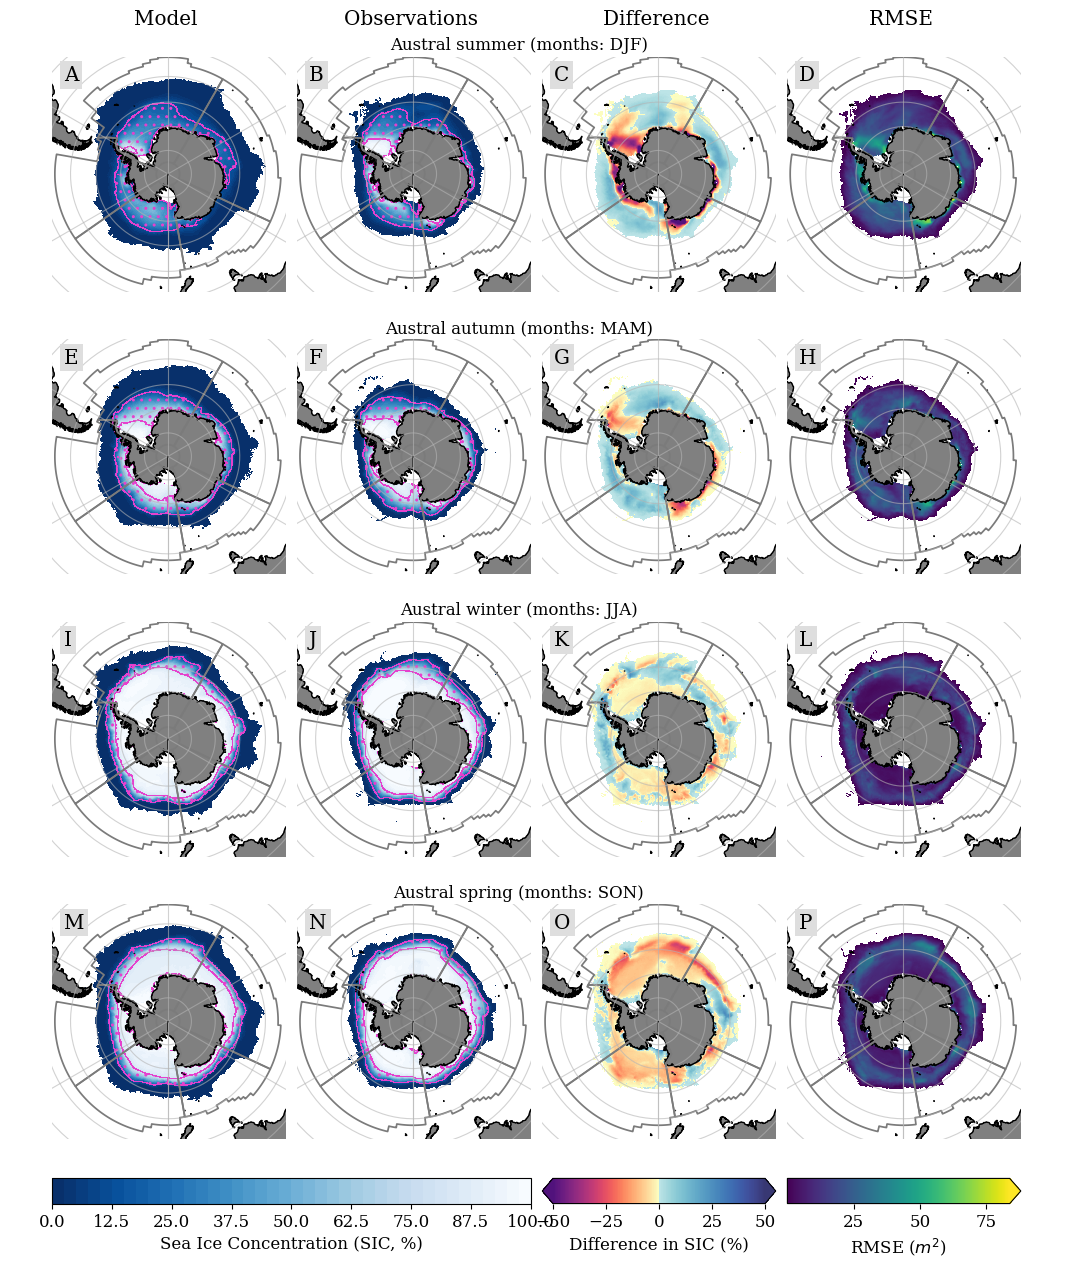

In [19]:
folder = os.path.join(varDict['climatologies'], '*seasonal*.nc')
fn = glob(folder)[0]

#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 15))

#######
###Colorbar settings
#Levels for colorbar
SIC_levels = np.arange(0, 101, 2.5)

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')
#######

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

#Defining season names
seasonName = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Defining datasets to be plotted
data = ['Model', 
        'Observations', 
        'Difference',
        'RMSE']
#Merge seasons and datasets
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonName)+1, 
                       ncols = len(data),
                       height_ratios = (1, 1, 1, 1, 0.1))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.15)

ax = {}

#Creating plot using loops
for i, coord in enumerate(counter):   
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    #Model data
    if coord[0] == 'Model':
        da = seasons_SIC[coord[1]].mean('time')*100
        p1 = da.where(da != 0).plot.\
        pcolormesh(ax = ax[i], cmap = plt.cm.Blues_r, 
                   levels = SIC_levels, transform = ccrs.PlateCarree(),
                   add_colorbar = False)
        
        #Adding MIZ limits
        miz_m = xr.where((da >= 15) & (da <= 80), 
                      1, np.nan).plot.contourf(hatches = ['..'], ax = ax[i], 
                                               transform = ccrs.PlateCarree(),
                                               colors = 'none', add_colorbar = False)
        [collection.set_edgecolor('#e541cd') for collection in miz_m.collections]
        [collection.set_linewidth(0.2) for collection in miz_m.collections]
        
    #Observational data
    elif coord[0] == 'Observations':
        da_o = seasons_SIC_obs[coord[1]].mean('time')*100
        p1 = da_o.where(da_o != 0).plot.\
        pcolormesh(ax = ax[i], 
                   cmap = plt.cm.Blues_r, 
                   levels = SIC_levels,
                   add_colorbar = False)
        
        #Adding MIZ limits
        miz_o = xr.where((da_o >= 15) & (da_o <= 80), 
                         1, np.nan).plot.contourf(hatches = ['..'], ax = ax[i], 
                                                  colors = 'none', add_colorbar = False)
        [collection.set_edgecolor('#e541cd') for collection in miz_o.collections]
        [collection.set_linewidth(0.2) for collection in miz_o.collections]
    
    #Differences
    elif coord[0] == 'Difference':
        #Remove zeroes
        da_d = clim_dif[coord[1]].where(clim_dif[coord[1]] != 0)
        #Plot data
        p2 = da_d.plot(ax = ax[i], 
                       cmap = mymap, norm = divnorm,
                       add_colorbar = False)
    #RMSE
    else:
        da_rmse = (rmse[coord[1]].where(rmse[coord[1]] != 0))*100
        p3 = da_rmse.plot.pcolormesh(ax = ax[i], # cmap = cmap_rmse, levels = np.arange(0, 301, 50), 
                                    add_colorbar = False)

    #Create counter using a list: i and j define the plot, while season refers to season
    MEASO_fixed.plot(color = '#7b7b7b', lw = 1.25, ax = ax[i])
    
    #Set title for each map
    if i < 4:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title(f'', y = 1.01)
    
    if i in [2, 6, 10, 14]:
        ax[i].text(-0.10, 1.05, f'{seasonName[coord[1]]}', horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes)
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    #Set extent shown
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #S#Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

ax_col = fig.add_subplot(gs[-1, 0:2])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', 
                  shrink = 0.5,
                  label = 'Sea Ice Concentration (SIC, %)')

ax_dif = fig.add_subplot(gs[-1, 2])
cb_dif = plt.colorbar(p2, cax = ax_dif, orientation = 'horizontal', 
                  extend = 'both', shrink = 0.5,
                  label = 'Difference in SIC (%)')

ax_rmse = fig.add_subplot(gs[-1, 3])
cb_rmse = plt.colorbar(p3, cax = ax_rmse, orientation = 'horizontal', 
                  extend = 'max', shrink = 0.5, label = 'RMSE (' + varDict['unit'] + ')')


#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:16]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 16:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Name with which figure will be saved
fn = 'SeasonalClim_Comp_Mod-Obs_NoTitle_SIC_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

# Calculating linear trends in sea ice concentration
SIC less than 0.1 were removed from model ouputs to match the algorithm used in the NASA Goddard data, which considers pixels with SIC estimates less than 0.1 as open water (see page 30 of [User Guide](https://nsidc.org/data/g02202/versions/3)).

## Calculating linear trends for model data

In [43]:
#Folder where linear trends will be saved
dir_out = varDict['linear_trends']
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results = {}

#Calculating linear trend for each season
for season in seasons_SIC:
    #Define file name
    fn = f'LinearTrend_SIC_{season}_1979-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(seasons_SIC[season][0].shape), 
                          dims = ["yt_ocean", "xt_ocean"], 
                          coords = dict(xt_ocean = seasons_SIC[season].xt_ocean.values, 
                                        yt_ocean = seasons_SIC[season].yt_ocean.values),
                          name = "std_err")

    LM_results[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends to avoid recalculating

In [64]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Linear*.nc'))

LM_results = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results[season] = xr.open_dataset(file[0])

### Plotting linear trends per for model data - Figure 5
Linear trends calculated from observations and model outputs are given in proportion per year. When plotting, data is multiplied by 1000 to transform units of linear trends to percentage per decade.  
**Non-significant trends have been blanked out**  
Non-significant refers to areas where the absolute value of the trend is less than the standard error.

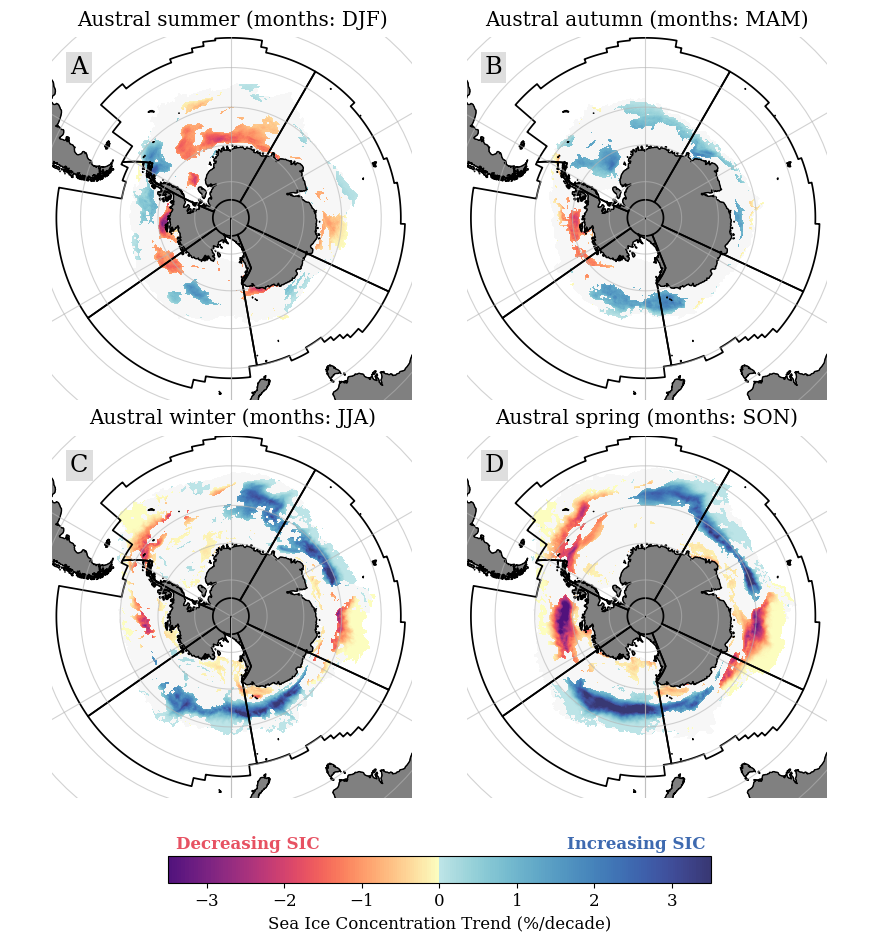

In [66]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -3.5, vcenter = 0, vmax = 3.5)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_results[season].coefficients
    #Standard errors
    se = LM_results[season].std_err
    
    #Create mask to cover non-significant trends (i.e., absolute trends less than std error
    #of trend)
    mask = xr.where(np.fabs(data) < se, 1, np.nan) 
    
    #Multiplying by 1000 to get percentages per decade
    p1 = (data*1000).where(data != 0).\
    plot.pcolormesh(ax = ax[season], cmap = mymap, 
                    transform = ccrs.PlateCarree(),
                    norm = divnorm, add_colorbar = False)
    #Apply mask
    mask.plot.contourf(colors = '#f7f7f7', ax = ax[season],
                       transform = ccrs.PlateCarree(), 
                       add_colorbar = False)
    
    #Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Removing longitude and latitude labels
    gl.xlabel_style = {'alpha': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  label = 'Sea Ice Concentration Trend (%/decade)')

#Add labels to improve readability
#Get colormap to extract colors for labels
cb.ax.text(1.65, 1.25, 'Increasing SIC', color = mymap(0.85), fontweight = 'bold')
cb.ax.text(-3.4, 1.25, 'Decreasing SIC', color = mymap(0.25), fontweight = 'bold')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:4]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

fn = 'SeasonalLinearTrends_SeaIceConcentration_1979-2018_NoTitle.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating standard deviation from model outputs

In [56]:
#Folder where std dev will be saved
file_out = varDict['linear_trends']
os.makedirs(file_out, exist_ok = True)

#Empty dictionary where results will be stored
std_season = {}

#Calculating standard deviation
for season in seasons_SIC:
    std_season[season] = seasons_SIC[season].std('time')
    #Creating file name to store outputs
    fn = f'StdDev_SIC_{season}_1979-2018.nc'
    std_season[season].to_netcdf(os.path.join(file_out, fn))

## Loading standard deviation to avoid recalculating

In [67]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Std*2018.nc'))

#Empty dictionary where results will be stored
std_season = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    std_season[season] = xr.open_dataarray(file[0])

## Plotting SIC standard deviation - Figure A.4

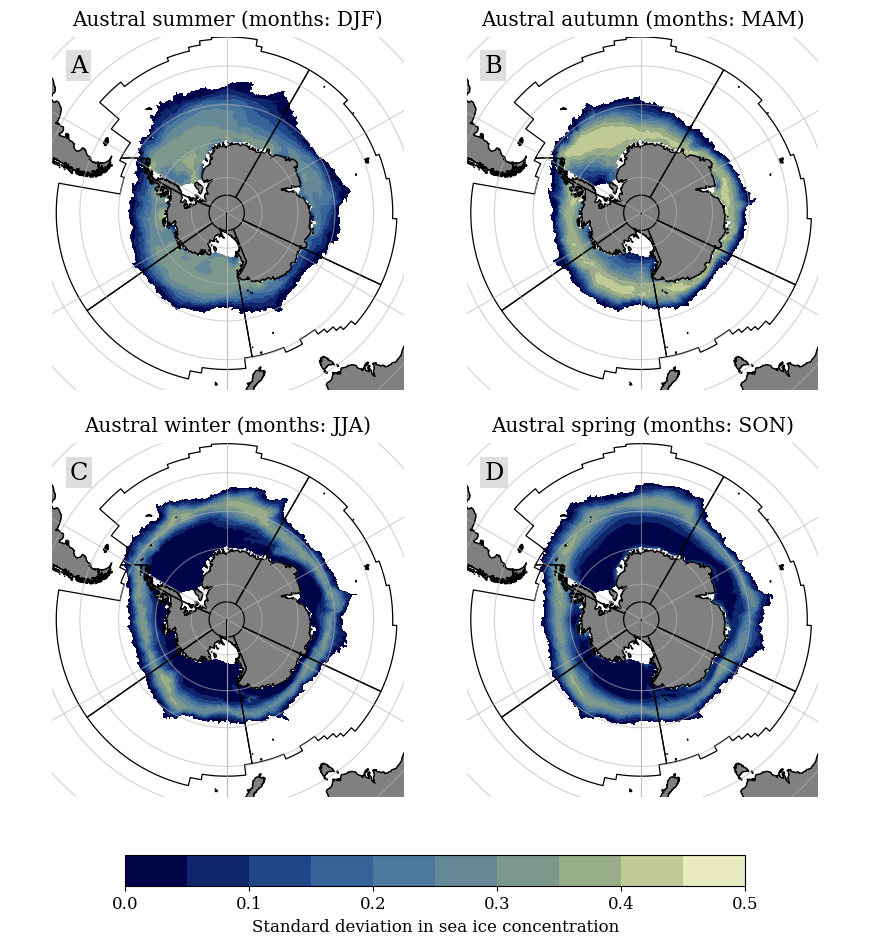

In [68]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))
levels = np.arange(0, 0.51, 0.05)

#Colormap from Scientific Colour Map package
davos = zsf.colourMaps('../../ScientificColourMaps6/', 'davos', rev = False)
#Shortening colormap to remove white
davos_short = mcolors.LinearSegmentedColormap.from_list('davos_short',
                                                        davos(np.linspace(0, .85, 128)))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.15)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    p1 = std_season[season].sel(yt_ocean = slice(-90, -50)).plot.\
    pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = ax[season], 
                  cmap = davos_short, levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    xr.where(std_season[season] == 0, 1, np.nan).plot.\
    contourf(ax = ax[season], transform = ccrs.PlateCarree(), cmap = 'white',
             add_colorbar = False)
                                                               
    MEASO_fixed.plot(color = 'black', lw = 0.9, ax = ax[season])
    
    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
        
    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Remove longitude and latitude labels
    gl.xlabel_style = {'alpha': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.8, pad = 0.06, 
                  label = 'Standard deviation in sea ice concentration')

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:4]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))
    
fn = 'StdDev_SeaIceConcentration_1979-2018_NoTitle.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight',
            pad_inches = 0.05)

## Calculating linear trends from observations

In [ ]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'Observations')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results_obs = {}

#Calculating linear trend for each season
for season in seasonName:
    #Define file name
    fn = f'LinearTrend_SIC_obs_{season}_1979-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(seasons_SIC_obs[season].time))
    #Extract values from SIC data and create a vector
    vals = seasons_SIC_obs[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "coefficients")

    pval_r = xr.DataArray(data = p.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(seasons_SIC_obs[season][0].shape), 
                          dims = ["ygrid", "xgrid"], 
                          coords = dict(xgrid = seasons_SIC_obs[season].xgrid.values, 
                                        ygrid = seasons_SIC_obs[season].ygrid.values),
                          name = "std_err")

    LM_results_obs[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results_obs[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends from observations from disk to avoid recalculation

In [70]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Observations/*2018.nc'))

LM_results_obs = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results_obs[season] = xr.open_dataset(file[0])
    LM_results_obs[season] = LM_results_obs[season].rename({'xgrid': 'x', 
                                                            'ygrid': 'y'})

## Calculating seasonal linear trends for regridded model data

In [40]:
#Folder where linear trends will be saved
dir_out = os.path.join(varDict['linear_trends'], 'Regridded')
#Ensure directory exists prior to saving results
os.makedirs(dir_out, exist_ok = True)

#Empty dictionary to store results
LM_results_mod = {}

#Calculating linear trend for each season
for season in reg_mod:
    #Define file name
    fn = f'LinearTrend_SIC_reg-mod_{season}_1979-2018.nc'

    #Extracting years to calculate linear trends
    time_ind = np.arange(0, len(reg_mod[season].time))
    #Extract values from SIC data and create a vector
    vals = reg_mod[season].values.reshape(len(time_ind), -1)

    #Save coefficients and pvalues for linear regression calculations
    slope, intercept, r, p, se = np.apply_along_axis(zsf.lm_yr, 0, vals, x = time_ind)

    #Reshaping coefficients and pvalues to original dimensions of the data array
    coef_r = xr.DataArray(data = slope.reshape(reg_mod[season][0].shape), 
                          dims = ["y", "x"],
                          coords = dict(x = reg_mod[season].xgrid.values, 
                                        y = reg_mod[season].ygrid.values),
                          name = "coefficients")   

    pval_r = xr.DataArray(data = p.reshape(reg_mod[season][0].shape), 
                          dims = ["y", "x"],
                          coords = dict(x = reg_mod[season].xgrid.values, 
                                        y = reg_mod[season].ygrid.values),
                          name = "p_values")
    
    std_err = xr.DataArray(data = se.reshape(reg_mod[season][0].shape), 
                          dims = ["y", "x"],
                          coords = dict(x = reg_mod[season].xgrid.values, 
                                        y = reg_mod[season].ygrid.values),
                          name = "std_err")

    LM_results_mod[season] = xr.merge([coef_r, pval_r, std_err])

    #Saving outputs
    LM_results_mod[season].to_netcdf(os.path.join(dir_out, fn))

### Loading linear trends calculated from regridded model outputs from disk to avoid recalculation

In [72]:
filelist = glob(os.path.join(varDict['linear_trends'], 'Regridded/*2018.nc'))

LM_results_mod = {}

for season in seasonName:
    file = [file for file in filelist if season in file]
    LM_results_mod[season] = xr.open_dataset(file[0])

## Calculating differences in seasonal trends

In [44]:
folder_out = os.path.join(varDict['linear_trends'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for key in LM_results_mod:
    #Load coefficients
    coefs_obs = LM_results_obs[key].coefficients
    coefs_mod = LM_results_mod[key].coefficients
    #Calculating differences
    LM_dif_obs_mod[key] = coefs_obs - coefs_mod
    #Saving differences (obs - mod)
    fn_magdif = f'DifMag_LinearTrend_SIC_obs-mod_{key}_1979-2018.nc'
    LM_dif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_magdif))
    
    #Calculating differences in direction
    #Observations
    obs_dir = xr.where(coefs_obs > 0, 1, -1)
    obs_dir = xr.where(coefs_obs == 0, 0, obs_dir)
    obs_dir = xr.where(np.isnan(coefs_obs), np.nan, obs_dir)
    #Model outputs
    mod_dir = xr.where(coefs_mod > 0, 1, -1)
    mod_dir = xr.where(coefs_mod == 0, 0, mod_dir)
    mod_dir = xr.where(np.isnan(coefs_mod), 
                       np.nan, mod_dir)
    #Difference in direction
    LM_dirdif_obs_mod[key] = obs_dir-mod_dir
    #Saving results
    fn_dirdif = f'DifDir_LinearTrend_SIC_obs-mod_{key}_1979-2018.nc'
    LM_dirdif_obs_mod[key].to_netcdf(os.path.join(folder_out, fn_dirdif))

### Loading differences from disk to avoid recalculation

In [73]:
#Getting files of magnitude and direction differences
filesDirDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifDir*2018.nc')))
filesMagDif = sorted(glob(os.path.join(varDict['linear_trends'], 'Regridded/DifMag*2018.nc')))

#Empty dictionary that will hold reprojected observations data
LM_dif_obs_mod = {}
LM_dirdif_obs_mod = {}

for season in seasonName:
    fileDir = [fd for fd in filesDirDif if season in fd]
    fileMag = [fm for fm in filesMagDif if season in fm]
    LM_dif_obs_mod[season] = xr.open_dataarray(fileMag[0])
    LM_dirdif_obs_mod[season] = xr.open_dataarray(fileDir[0])

## Plotting differences in trend magnitude between observations and model outputs

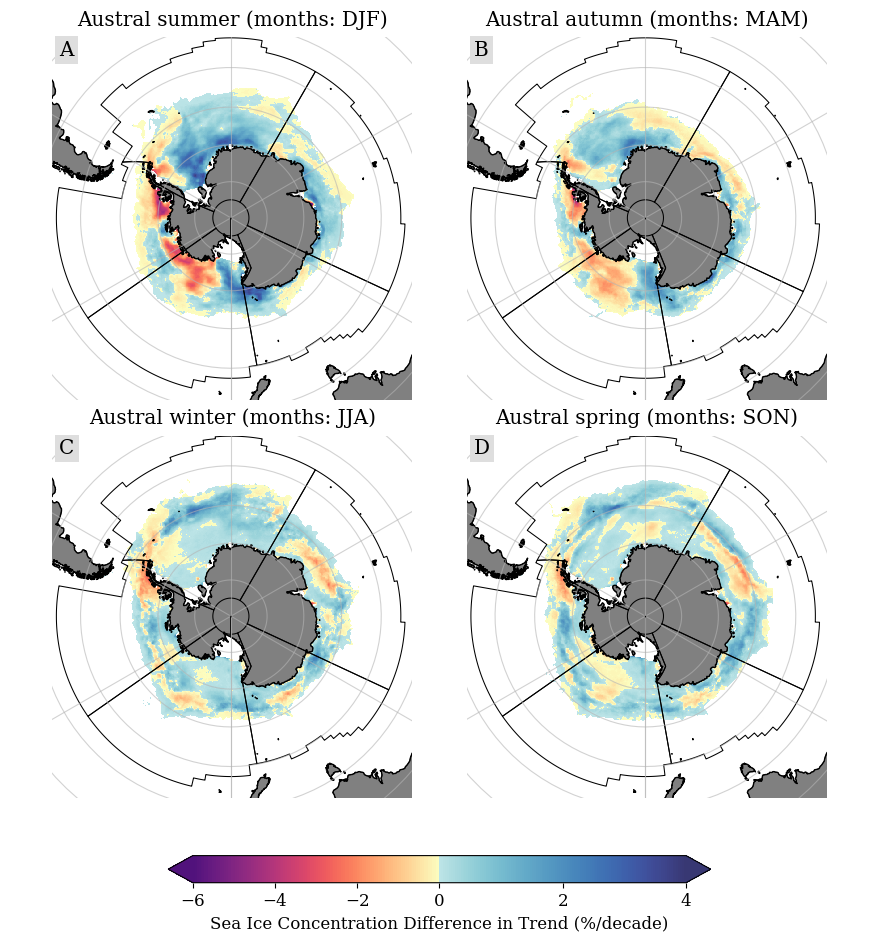

In [75]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -6, vcenter = 0, vmax = 4)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dif_obs_mod[season]*1000
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = mymap, norm = divnorm,
                              add_colorbar = False)
    xr.where(data > 5, True, 0).plot.contour(colors = 'red', add_colorbar = False,
                          linewidths = 0.1, ax = ax[season])
    xr.where(data > 10, True, 0).plot.contour(colors = 'red', add_colorbar = False,
                          linewidths = 0.15, ax = ax[season], linestyle = '-')
    
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])
    #Plot any areas with zero trends as white
    xr.where(data == 0, 1, np.nan).plot.contourf(ax = ax[season], cmap = 'white',
                                                 add_colorbar = False)

    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Remove longitude and latitude labels
    gl.xlabel_style = {'alpha': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, extend = 'both',
                  label = 'Sea Ice Concentration Difference in Trend (%/decade)')

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:4]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.02, .95, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

fn = 'Diffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

### Plotting differences in trend direction between observations and model outputs - Figure A.3

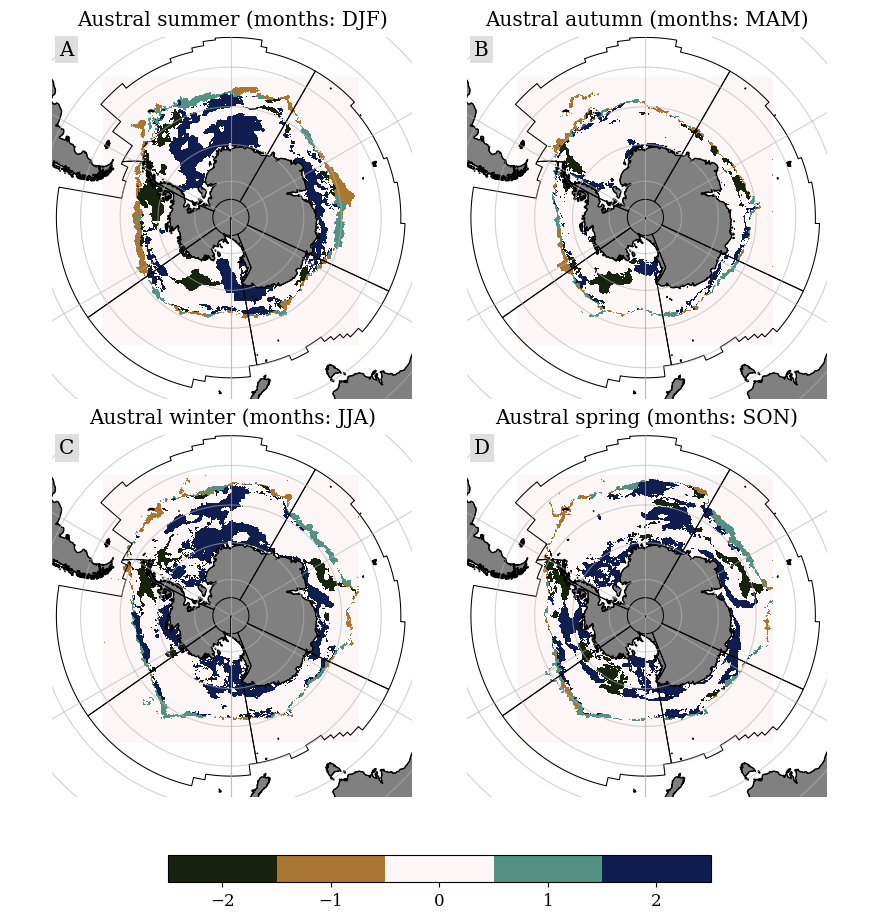

In [76]:
#Ensure folder where figures will be saved exists
folder_out = varDict['lm_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (10, 12.5))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining season names
seasonNames = {'Summer': 'Austral summer (months: DJF)', 
              'Autumn': 'Austral autumn (months: MAM)', 
              'Winter': 'Austral winter (months: JJA)', 
              'Spring': 'Austral spring (months: SON)'}

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)
########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = 2, ncols = 2)
#Change the width between each plot
gs.update(wspace = 0.15, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'Summer'), (0, 1, 'Autumn'), 
                     (1, 0, 'Winter'), (1, 1, 'Spring')]:
    ax[season] = fig.add_subplot(gs[i, j], projection = projection)
    #Extract information for each season and start plotting
    data = LM_dirdif_obs_mod[season]
    #Creating a colorbar from 'tarn' that contains five levels
    cmap = plt.get_cmap(cm.cm.tarn, 5)
    #Multiplying by 1000 to get percentages per decade
    p1 = data.plot.pcolormesh(ax = ax[season], cmap = cmap, 
                              #Levels and limits are 0.5 units wider than 
                              #actual measurements
                              levels = np.arange(-2.5, 2.6, 1),
                              vmin = -2.5, vmax = 2.5,
                              add_colorbar = False)
    MEASO_fixed.plot(color = 'black', lw = 0.75, ax = ax[season])

    #Set title for each subplot.
    ax[season].set_title(seasonNames[season], y = 1.01)
    #Remove x and y axes labels
    ax[season].set_ylabel("")
    ax[season].set_xlabel("")
      
    #Add land and coastlines
    ax[season].add_feature(land_50m)
    ax[season].coastlines(resolution = '50m')
    
    #Set map extent
    ax[season].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[season].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Remove longitude and latitude labels
    gl.xlabel_style = {'alpha': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[season].spines.values()]
    [t.set_visible(False) for t in ax[season].get_xticklines()]
    [t.set_visible(False) for t in ax[season].get_yticklines()]

#Set colourbar to be horizontal, 80% its original size and a distance equal to 9% of total figure area from the plot
cb = fig.colorbar(p1, ax = [ax[a] for a in ax],
                  orientation = 'horizontal', 
                  shrink = 0.7, pad = 0.06, 
                  #Ticks in colorbar match the data range
                  ticks = np.arange(-2, 2.1),
                  label = '')

#Labelling plots
#Getting the alphabet in upper case
labels = string.ascii_uppercase[0:4]
#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.02, .95, labels[i], transform = ax[a].transAxes, fontsize = 'large',
           bbox = dict(facecolor = '#dedede', edgecolor = 'none', pad = 3.0))

fn = 'DirDiffs_Obs-Mod_SeasonalTrends_SeaIceConcentration_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, 
            bbox_inches = 'tight', pad_inches = 0.05)

# Calculating SIC summary statistics - Table 2

## Loading MEASO regions

In [9]:
#Defining sector names in order
sectorNames = ['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific']

In [10]:
#Loading mask
regions = xr.load_dataarray('../SupportingData/Masks/MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific'])

In [121]:
climdata = SIC.where(SIC >= 0.1).fillna(0)
SIC_clim = climdata.where(climdata > 0)*100

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIC = {}
#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    for season, da in SIC_clim.groupby('time.season'):
        clip = da*MEASOregions[sector]
        print(sector, season, 
              clip.chunk(dict(time=-1)).quantile([0.25, 0.5, 0.75]).round(2).values)

Atlantic DJF [30.81 59.45 80.97]
Atlantic JJA [92.41 95.33 98.32]
Atlantic MAM [61.63 95.35 98.75]
Atlantic SON [84.89 90.36 93.66]
Central Indian DJF [21.57 38.51 56.67]
Central Indian JJA [75.47 90.64 95.31]
Central Indian MAM [36.29 70.63 92.13]
Central Indian SON [75.14 88.1  93.14]
East Indian DJF [19.38 34.63 56.92]
East Indian JJA [68.73 88.86 93.5 ]
East Indian MAM [39.82 78.04 92.55]
East Indian SON [58.24 82.22 89.47]
West Pacific DJF [29.97 55.2  76.08]
West Pacific JJA [90.54 94.46 96.8 ]
West Pacific MAM [69.82 94.62 98.05]
West Pacific SON [85.65 90.7  93.95]
East Pacific DJF [23.53 44.9  69.98]
East Pacific JJA [74.02 93.12 97.08]
East Pacific MAM [45.01 84.33 96.86]
East Pacific SON [68.2  89.43 94.62]


## RMSE calculations from regridded model data and observations

In [34]:
iceObs = iceObs.sel(time = slice('1978-12', '2018-11'))*100
reg_mod_all = reg_mod_all.sel(time = slice('1978-12', '2018-11'))*100
#Matching time values in observations and model data
iceObs['time'] = reg_mod_all.time

In [41]:
#Assigning CRS to MEASO regions
MEASO_fixed = MEASO_fixed.set_crs(epsg = 3976)

#Assigning CRS to observational data
iceObs.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
iceObs.rio.write_crs(MEASO_fixed.crs, inplace = True)

#Assigning CRS to regridded model data
reg_mod_all.rio.set_spatial_dims(x_dim = 'xgrid', y_dim = 'ygrid', inplace = True)
reg_mod_all.rio.write_crs(MEASO_fixed.crs, inplace = True)

<xarray.DataArray (time: 480, ygrid: 332, xgrid: 316)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1978-12-31T12:00:00 ... 2018-11-30T12:...
    lat          (ygrid, xgrid) float64 ...
    lon          (ygrid, xgrid) float64 ...
  * ygrid        (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid        (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    spatial_ref  int64 0

In [42]:
#Ensuring output folder exists
out_folder = os.path.join(varDict['clipped_data'], 'Observations')
#Ensuring file exists
os.makedirs(out_folder, exist_ok = True)

#Empty list to store clipped data 
clipped_obs = {}
clipped_reg = {}

#Clipping data using MEASO sectors
for sec in np.unique(MEASO.sector):
    shp = MEASO.query(f'sector == "{sec}"')
    #Observations
    for season, da in iceObs.groupby('time.season'):
        #Transforming to percentage
        clipped_obs[f'{sec}_{season}'] = da.rio.clip(shp.geometry, invert = False)
    #Regridded model
    for season, da in reg_mod_all.groupby('time.season'):
        clipped_reg[f'{sec}_{season}'] = da.rio.clip(shp.geometry, invert = False)

In [43]:
#Creating empty pandas dataframe to store results
error = pd.DataFrame({'rmse':[], 'key': []})

#Looping through each sector/season combination to calculate stats
for i, key in enumerate(clipped_reg):
    vals = []
    #RMSE calculation
    rmse = np.sqrt(((clipped_reg[key]-clipped_obs[key])**2).mean()).values.tolist()
    #Merging results together
    vals.append(rmse)
    #Adding the sector/season
    vals.append(key)
    error.loc[i] = vals
    
#Checking results
error

,rmse,key
0,17.406176,Atlantic_DJF
1,10.558816,Atlantic_JJA
2,11.721662,Atlantic_MAM
3,13.168704,Atlantic_SON
4,15.676490,Central Indian_DJF
5,9.431808,Central Indian_JJA
6,9.815217,Central Indian_MAM
7,13.786687,Central Indian_SON
8,18.067879,East Indian_DJF
9,7.677754,East Indian_JJA
